In [339]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
from datetime import datetime
from time import sleep

from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.support.wait import WebDriverWait

import re
import csv

from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [340]:
def get_tweet_data(card):
    """Extract data from tweet card"""
    username = card.find_element_by_xpath('.//span').text
    try:
        handle = card.find_element_by_xpath('.//span[contains(text(), "@")]').text
    except NoSuchElementException:
        return
    
    try:
        postdate = card.find_element_by_xpath('.//time').get_attribute('datetime')
    except NoSuchElementException:
        return
    
    comment = card.find_element_by_xpath('.//div[2]/div[2]/div[1]').text
    responding = card.find_element_by_xpath('.//div[2]/div[2]/div[2]').text
    text = comment + ' ' + responding
    #text = comment
    reply_cnt = card.find_element_by_xpath('.//div[@data-testid="reply"]').text
    retweet_cnt = card.find_element_by_xpath('.//div[@data-testid="retweet"]').text
    like_cnt = card.find_element_by_xpath('.//div[@data-testid="like"]').text
    
    # get a string of all emojis contained in the tweet
    """Emojis are stored as images... so I convert the filename, which is stored as unicode, into 
    the emoji character."""
    emoji_tags = card.find_elements_by_xpath('.//img[contains(@src, "emoji")]')
    emoji_list = []
    for tag in emoji_tags:
        filename = tag.get_attribute('src')
        try:
            emoji = chr(int(re.search(r'svg\/([a-z0-9]+)\.svg', filename).group(1), base=16))
        except AttributeError:
            continue
        if emoji:
            emoji_list.append(emoji)
    emojis = ' '.join(emoji_list)
    
    tweet = (username, handle, postdate, text, emojis, reply_cnt, retweet_cnt, like_cnt)
    return tweet

In [343]:
#Where the file is located
options = webdriver.ChromeOptions()
options.add_argument("user-data-dir=/Users/frankjimenez/Library/Application Support/Google/Chrome/Default")
PATH = "/Applications/chromedriver"
driver = webdriver.Chrome(PATH)

driver.get("https://twitter.com/explore")
wait = WebDriverWait(driver,10)

sleep(10)
search_input = driver.find_element_by_xpath('//input[@aria-label="Search query"]')
search_input.send_keys('Superleague lang:en')
search_input.send_keys(Keys.RETURN)
sleep(10)

# navigate to historical 'latest' tab
driver.find_element_by_link_text('Latest').click()

# get all tweets on the page
data = []
tweet_ids = set()
last_position = driver.execute_script("return window.pageYOffset;")
scrolling = True

while scrolling:
    page_cards = driver.find_elements_by_xpath('//div[@data-testid="tweet"]')
    for card in page_cards[-15:]:
        tweet = get_tweet_data(card)
        if tweet:
            tweet_id = ''.join(tweet)
            if tweet_id not in tweet_ids:
                tweet_ids.add(tweet_id)
                data.append(tweet)
            
    scroll_attempt = 0
    while True:
        # check scroll position
        driver.execute_script('window.scrollTo(0, document.body.scrollHeight);')
        sleep(2)
        curr_position = driver.execute_script("return window.pageYOffset;")
        if last_position == curr_position:
            scroll_attempt += 1
            
            # end of scroll region
            if scroll_attempt >= 3:
                scrolling = False
                break
            else:
                sleep(2) # attempt another scroll
        else:
            last_position = curr_position
            break

# close the web driver
driver.close()

AttributeError: 'NoneType' object has no attribute 'text'

In [344]:
len(data)

850

In [345]:
from textblob import TextBlob

In [346]:
import pandas as pd

tweetList = []
for i in data:
    tweetList.append(i)

In [347]:
df = pd.DataFrame(tweetList)
df = df.rename(columns={df.columns[0]: 'username', df.columns[1]: 'handle', df.columns[2]: 'date', df.columns[3]: 'message', df.columns[4]: 'emojis', df.columns[5]: 'reply_cnt', df.columns[6]: 'retweet_cnt', df.columns[7]: 'like_cnt'})
df.head()

,username,handle,date,message,emojis,reply_cnt,retweet_cnt,like_cnt
0,Final Scorezz,@finalscorezz,2021-04-25T21:50:07.000Z,Is the emergence and fall of the #SuperLeague ...,,,,
1,Stephen Base,@stephenbase67,2021-04-25T21:50:04.000Z,Looking for a palate cleanser after the bad ta...,⚽ ❤,,,
2,Nicholas Gorrell,@njgorrell,2021-04-25T21:50:02.000Z,Replying to \n@maxrushden\n @guardian_sport\n ...,,,,
3,Nula Suchet,@nulasuchet,2021-04-25T21:49:43.000Z,Boris Johnson urged to reveal if he endorsed S...,,,,
4,,@dwthfcc,2021-04-25T21:49:43.000Z,Replying to \n@Domboloo_ Super league was our ...,,,,


In [348]:
def cleanTxt(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#', '', text)
    test = re.sub(r'RT[\s]+', '', text)
    tes = re.sub(r'https?:\/\/\S+', '', text)
    return text

In [349]:
def cleanTweets(text):
    text = re.sub(r'#', ' ', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub('(?:\s)@[^, ]*', '', text)

    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'Replying to[\s]+', '', text)
    return text

In [350]:
df['message'] = df['message'].apply(cleanTweets)

In [351]:
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
    return TextBlob(text).sentiment.polarity

df['subjectivity'] = df['message'].apply(getSubjectivity)
df['polarity'] = df['message'].apply(getPolarity)
df.head()

,username,handle,date,message,emojis,reply_cnt,retweet_cnt,like_cnt,subjectivity,polarity
0,Final Scorezz,@finalscorezz,2021-04-25T21:50:07.000Z,Is the emergence and fall of the SuperLeague ...,,,,,0.571429,0.214286
1,Stephen Base,@stephenbase67,2021-04-25T21:50:04.000Z,Looking for a palate cleanser after the bad ta...,⚽ ❤,,,,0.466667,-0.113333
2,Nicholas Gorrell,@njgorrell,2021-04-25T21:50:02.000Z,and 3 others With fans saying “we want our col...,,,,,0.541667,0.133333
3,Nula Suchet,@nulasuchet,2021-04-25T21:49:43.000Z,Boris Johnson urged to reveal if he endorsed S...,,,,,0.666667,0.333333
4,,@dwthfcc,2021-04-25T21:49:43.000Z,Super league was our ticket out the hood,,,,,0.666667,0.333333


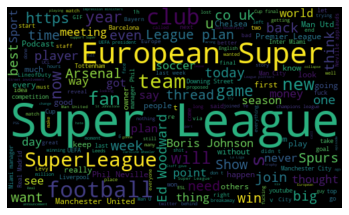

In [353]:
allWords = ' '.join([twts for twts in df['message']])
wordCloud = WordCloud(width= 500, height = 300, random_state = 21, max_font_size = 110).generate(allWords)

plt.imshow(wordCloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [354]:
def getAnalysis(score):
    if score < 0:
        return 'negative'
    elif score == 0:
        return 'neutral'
    else:
        return 'positive'

df['analysis'] = df['polarity'].apply(getAnalysis)
df.head()

,username,handle,date,message,emojis,reply_cnt,retweet_cnt,like_cnt,subjectivity,polarity,analysis
0,Final Scorezz,@finalscorezz,2021-04-25T21:50:07.000Z,Is the emergence and fall of the SuperLeague ...,,,,,0.571429,0.214286,positive
1,Stephen Base,@stephenbase67,2021-04-25T21:50:04.000Z,Looking for a palate cleanser after the bad ta...,⚽ ❤,,,,0.466667,-0.113333,negative
2,Nicholas Gorrell,@njgorrell,2021-04-25T21:50:02.000Z,and 3 others With fans saying “we want our col...,,,,,0.541667,0.133333,positive
3,Nula Suchet,@nulasuchet,2021-04-25T21:49:43.000Z,Boris Johnson urged to reveal if he endorsed S...,,,,,0.666667,0.333333,positive
4,,@dwthfcc,2021-04-25T21:49:43.000Z,Super league was our ticket out the hood,,,,,0.666667,0.333333,positive


,username,handle,date,message,emojis,reply_cnt,retweet_cnt,like_cnt,subjectivity,polarity,analysis
0,Pedro Reyes,@ReyesRC19,2021-04-24T20:52:44.000Z,"Yes, Flore, you need the Superligue, you're f...",,,1,,0.750000,0.300000,positive
1,Kilam,@Kilam_RP,2021-04-24T19:19:24.000Z,and 3 others Hein?,👹,,,,0.000000,0.000000,neutral
2,Kilam,@Kilam_RP,2021-04-24T18:30:03.000Z,", and Omar ?",👹,1,,,0.000000,0.000000,neutral
3,𝕄𝕒𝕣𝕜 ❁,@rpmark_,2021-04-24T14:41:57.000Z,and 2 others Pleure,,1,,,0.000000,0.000000,neutral
4,alf s,@Helios2012,2021-04-24T14:20:45.000Z,Today the god of football demonstrate why the ...,,,,,0.400000,0.800000,positive
5,𝐶𝑎𝑚𝑖𝑙,@CamilSM_,2021-04-24T12:31:51.000Z,and 2 others 10 buts d'Antho,⚔,,,,0.000000,0.000000,neutral
6,Konrad Söllich,@KonradSollich,2021-04-24T10:41:19.000Z,Oh yes! Arsenal. They should join Superligue a...,,,,,1.000000,0.000000,neutral
7,Crocket,@Crocket81893187,2021-04-23T23:16:24.000Z,", and Hala Madrid.... I hope that you win t...",,1,,1,0.200000,0.400000,positive
8,Ebadaoui younes البداوي يونس,@EbadaouiY,2021-04-23T22:07:42.000Z,and Superligue knows Right Now who manigance ...,,,,,0.767857,0.342857,positive
9,Ebadaoui younes البداوي يونس,@EbadaouiY,2021-04-23T22:07:30.000Z,Superligue knows Right Now who manigance again...,🚨,,,,0.655751,0.165059,positive


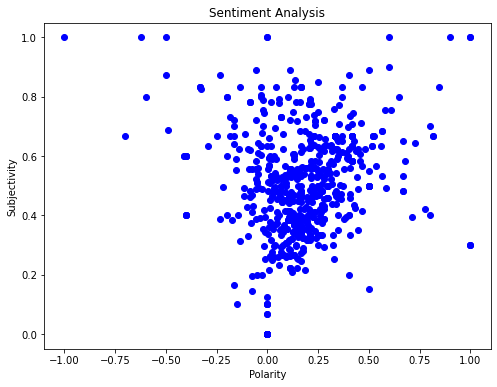

In [355]:
plt.figure(figsize=(8,6))
for i in range(0, df.shape[0]):
    plt.scatter(df['polarity'][i], df['subjectivity'][i], color='Blue')

plt.title('Sentiment Analysis')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.show()

In [356]:
ptweets = df[df.analysis == 'positive']
ptweets = ptweets['message']

round((ptweets.shape[0] / df.shape[0]) *100, 1)

77.1

In [357]:
ntweets = df[df.analysis == 'negative']
ntweets = ntweets['message']

round((ntweets.shape[0] / df.shape[0]) *100, 1)

11.9

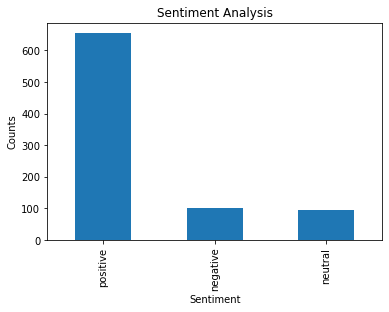

In [358]:
plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
df.analysis.value_counts().plot(kind='bar')
plt.show()